In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

np.random.seed(601)

from datetime import datetime, timedelta

from tqdm import tqdm_notebook
import time

from haversine import haversine

import pickle

from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

# 1. 데이터 Load

In [2]:
train = pd.read_csv('data/train.csv', parse_dates=['pickup_datetime','dropoff_datetime'])
test = pd.read_csv('data/test.csv', parse_dates=['pickup_datetime'])
sample_submission = pd.read_csv('data/sample_submission.csv')

In [ ]:
# 순수하게 Load 해서 거리만 넣은 피클 
"""
with open("train.pkl", "wb") as f:
    pickle.dump(train, f)
    
with open("test.pkl", "wb") as f:
    pickle.dump(test, f)    
"""
with open("train.pkl", "rb") as f:
    train = pickle.load(f)    
    
with open("test.pkl", "rb") as f:
    test = pickle.load(f)        

## 외부데이터

In [ ]:
fr1 = pd.read_csv('new-york-city-taxi-with-osrm/fastest_routes_train_part_1.csv',
                  usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps'])
fr2 = pd.read_csv('new-york-city-taxi-with-osrm/fastest_routes_train_part_2.csv',
                  usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
test_street_info = pd.read_csv('new-york-city-taxi-with-osrm/fastest_routes_test.csv',
                               usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])

In [ ]:
train_street_info = pd.concat((fr1, fr2))

train = train.merge(train_street_info, how='left', on='id')
test = test.merge(test_street_info, how='left', on='id')
train_street_info.head()

In [ ]:
train.isnull().sum()
test.isnull().sum().sum()

In [ ]:
idx = train[(train.total_distance.isnull()==True)].index
train = train.drop(idx)

In [ ]:
train.head()
test.head()
sample_submission.head()

# 2. 데이터 전처리
## 2.1 EDA

In [ ]:
train.shape
test.shape
sample_submission.shape

In [ ]:
train.columns
test.columns
sample_submission.columns

In [ ]:
train.info()

In [ ]:
train.describe()

### 기간

In [ ]:
train.pickup_datetime.min(), train.pickup_datetime.max()
# 년도는 동일, 월, 일, 시간, 요일 추출 

test.pickup_datetime.min(), test.pickup_datetime.max()

In [ ]:
train.head()

### Outlier - 운행기간

In [ ]:
# 운행 기간 Outlier 삭제 
train[(train.dropoff_datetime - train.pickup_datetime).dt.days > 1]
idx = train[(train.dropoff_datetime - train.pickup_datetime).dt.days > 1].index

train = train.drop(idx)

In [ ]:
train.shape # (1458644, 12) -> (1458640, 12)

### Target Date 시각화

In [ ]:
train.trip_duration.plot()

### Missing Value

In [ ]:
train.isnull().sum().sum()
test.isnull().sum().sum()

### Value Counts

In [ ]:
def value_counts(df):
    for col in df.columns:
        print(col)
        print(train[col].value_counts())
        
value_counts(train[['passenger_count']])        

In [ ]:
train[train['passenger_count'] == 7]
test[test['passenger_count'] == 7]

In [ ]:
train[train['dist'] == 0].head()
test[test['dist'] == 0].head()

In [ ]:
# 위도 경도 같은 건 삭제 

idx = train[train['dist'] == 0].index

train = train.drop(idx)

In [ ]:
train

In [ ]:
pd.crosstab(train['vendor_id'], train['store_and_fwd_flag'], margins=True)

### trip_duration dropoff_datetime pickup_datetime 관계 확인 -> dropoff_datetime 빼고 학습?

In [ ]:
(train['trip_duration'] == (train['dropoff_datetime'] - train['pickup_datetime']).astype('timedelta64[s]')).value_counts()

## 시각화
### 지역: 경도/위도

#### x: 위도(latitude)
#### y: 경도(longitude) 

(pickup_latitude, pickup_longitude) -> (dropoff_latitude, dropoff_longitude)

In [ ]:
InteractiveShell.ast_node_interactivity = "none"

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20, 10), sharex=True, sharey=True)
ax[0].set_title('pickup point')
ax[0].set_xlabel('latitude')
ax[0].set_ylabel('longitude')
ax[0].scatter(train.pickup_latitude, train.pickup_longitude, marker='o')
ax[1].set_title('dropoff point')
ax[1].set_xlabel('latitude')
ax[1].set_ylabel('longitude')
ax[1].scatter(train.dropoff_latitude, train.dropoff_longitude, marker='o')
plt.show()

In [ ]:
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
# pickup point outlier 
idx = train[(train.pickup_longitude == train.pickup_longitude.min()) | (train.pickup_latitude == train.pickup_latitude.max())].index
train = train.drop(idx)

In [ ]:
train.shape # (1458640, 12) -> (1458638, 12)

In [ ]:
InteractiveShell.ast_node_interactivity = "none"

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20, 10))
ax[0].set_title('pickup point')
ax[0].set_xlabel('latitude')
ax[0].set_ylabel('longitude')
ax[0].scatter(train.pickup_latitude, train.pickup_longitude, marker='o')
ax[1].set_title('dropoff point')
ax[1].set_xlabel('latitude')
ax[1].set_ylabel('longitude')
ax[1].scatter(train.dropoff_latitude, train.dropoff_longitude, marker='o')
plt.show()

In [ ]:
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
len(train) # 1458637
train.index.size

outlier 가져갈것인가?

In [ ]:
start = time.time()  # 시작 시간 저장

# total = tqdm_notebook(range(len(train))) # outlier 삭제로 전체 건수 loop 안됨 

fig, ax = plt.subplots(1,1, figsize=(20, 10))

for i in train.index: # total:
    plt.arrow(train.pickup_latitude[i], train.pickup_longitude[i]
            , (train.dropoff_latitude[i]-train.pickup_latitude[i])
            , (train.dropoff_longitude[i]-train.pickup_longitude[i]), head_width=0.01, head_length=0.01, fc='k', ec='k')
    
ax.set_title('start -> end arrow')
ax.set_xlim(32, 42)
ax.set_ylim(-90, -60)

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

In [ ]:
train['dist'].sort_values()

In [ ]:
train[train['dist'] == train['dist'].max()]

In [ ]:
# 시간대비 거리가 너무 김 outlier 
idx = train[train['dist'] == train['dist'].max()].index
train = train.drop(idx)

In [ ]:
train.shape # (1458638, 12) -> (1458637, 12)

In [ ]:
start = time.time()  # 시작 시간 저장

# total = tqdm_notebook(range(len(train))) # outlier 삭제로 전체 건수 loop 안됨 

fig, ax = plt.subplots(1,1, figsize=(20, 10))

for i in train.index: # total:
    plt.arrow(train.pickup_latitude[i], train.pickup_longitude[i]
            , (train.dropoff_latitude[i]-train.pickup_latitude[i])
            , (train.dropoff_longitude[i]-train.pickup_longitude[i]), head_width=0.01, head_length=0.01, fc='k', ec='k')
    
ax.set_title('start -> end arrow')
ax.set_xlim(32, 42)
ax.set_ylim(-90, -60)

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

### 위도 경도로 거리 구하기 -> haversine

In [ ]:
train['dist'] = 0.0

start = time.time()  # 시작 시간 저장

total = tqdm_notebook(range(len(train)))

for i in total:
    train['dist'][i] = haversine((train.pickup_latitude[i], train.pickup_longitude[i]), (train.dropoff_latitude[i], train.dropoff_longitude[i]))
print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

In [ ]:
test['dist'] = 0.0

start = time.time()  # 시작 시간 저장

total = tqdm_notebook(range(len(test)))

for i in total:
    test['dist'][i] = haversine((test.pickup_latitude[i], test.pickup_longitude[i]), (test.dropoff_latitude[i], test.dropoff_longitude[i]))
print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

In [ ]:
InteractiveShell.ast_node_interactivity = "all"

In [9]:
#Function aiming at calculating distances from coordinates
def ft_haversine_distance(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371 #km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

#Add distance feature
train['distance'] = ft_haversine_distance(train['pickup_latitude'].values,
                                                 train['pickup_longitude'].values, 
                                                 train['dropoff_latitude'].values,
                                                 train['dropoff_longitude'].values)
test['distance'] = ft_haversine_distance(test['pickup_latitude'].values, 
                                                test['pickup_longitude'].values, 
                                                test['dropoff_latitude'].values, 
                                                test['dropoff_longitude'].values)

In [10]:
#Function aiming at calculating the direction
def ft_degree(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371 #km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

#Add direction feature
train['direction'] = ft_degree(train['pickup_latitude'].values,
                                train['pickup_longitude'].values,
                                train['dropoff_latitude'].values,
                                train['dropoff_longitude'].values)
test['direction'] = ft_degree(test['pickup_latitude'].values,
                                  test['pickup_longitude'].values, 
                                  test['dropoff_latitude'].values,
                                  test['dropoff_longitude'].values)

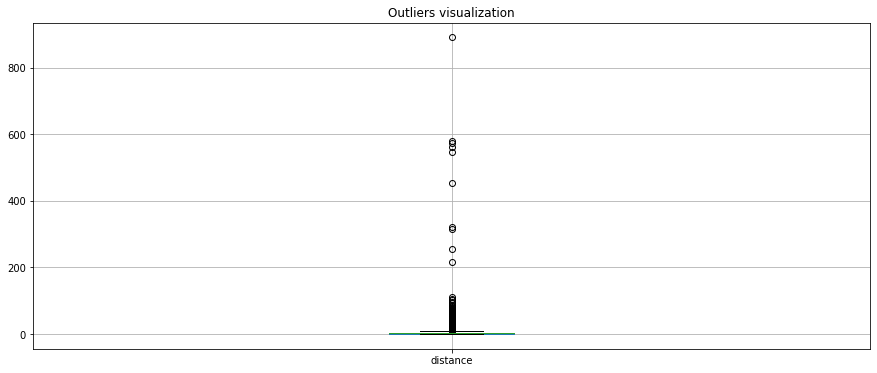

In [12]:
#Visualize univariate outliers
plt.subplots(figsize=(15,6))
plt.title("Outliers visualization")
train[['distance']].boxplot();

In [13]:
#Remove distance outliers
train = train[(train.distance < 200)]

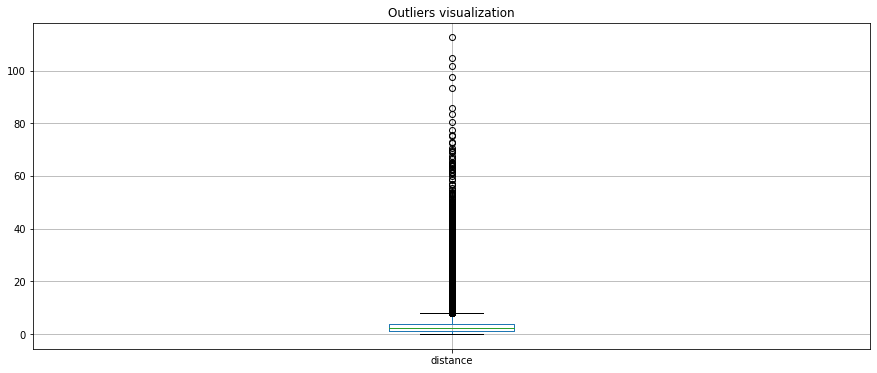

In [15]:
#Visualize univariate outliers
plt.subplots(figsize=(15,6))
plt.title("Outliers visualization")
train[['distance']].boxplot();

In [ ]:
train.shape

In [3]:
#Only keep trips that lasted less than 5900 seconds
train = train[(train.trip_duration < 5900)]

In [ ]:
#Visualize univariate outliers
plt.subplots(figsize=(25,6))
plt.title("Outliers visualization")
train.boxplot();

In [4]:
#Only keep trips with passengers
train = train[(train.passenger_count > 0)]

In [ ]:
train.shape

In [ ]:
#Plot pickup positions to visualize outliers
pickup_longitude = list(train.pickup_longitude)
pickup_latitude = list(train.pickup_latitude)
plt.subplots(figsize=(18,6))
plt.plot(pickup_longitude, pickup_latitude, '.', alpha = 1, markersize = 10)
plt.xlabel('pickup_longitude')
plt.ylabel('pickup_latitude')
plt.show()

In [5]:
#Remove position outliers
train = train[(train.pickup_longitude > -100)]
train = train[(train.pickup_latitude < 50)]

In [ ]:
#Plot pickup positions to visualize outliers
pickup_longitude = list(train.pickup_longitude)
pickup_latitude = list(train.pickup_latitude)
plt.subplots(figsize=(18,6))
plt.plot(pickup_longitude, pickup_latitude, '.', alpha = 1, markersize = 10)
plt.xlabel('pickup_longitude')
plt.ylabel('pickup_latitude')
plt.show()

In [ ]:
#Plot dropoff positions to visualize outliers
dropoff_longitude = list(train.dropoff_longitude)
dropoff_latitude = list(train.dropoff_latitude)
plt.subplots(figsize=(18,6))
plt.plot(dropoff_longitude, dropoff_latitude, '.', alpha = 1, markersize = 10)
plt.xlabel('dropoff_longitude')
plt.ylabel('dropoff_latitude')
plt.show()

In [ ]:
#train = train[(train.dropoff_longitude < -70) & (train.dropoff_longitude > -80)]
#train = train[(train.dropoff_latitude < 50)]

In [ ]:
#Plot dropoff positions to visualize outliers
dropoff_longitude = list(train.dropoff_longitude)
dropoff_latitude = list(train.dropoff_latitude)
plt.subplots(figsize=(18,6))
plt.plot(dropoff_longitude, dropoff_latitude, '.', alpha = 1, markersize = 10)
plt.xlabel('dropoff_longitude')
plt.ylabel('dropoff_latitude')
plt.show()

In [ ]:
#Visualize distance outliers
train.boxplot(column='distance', return_type='axes');

In [ ]:
#Remove distance outliers
train = train[(train.distance < 200)]

In [ ]:
#Visualize distance outliers
train.boxplot(column='distance', return_type='axes');

In [16]:
#Create speed feature
train['speed'] = train.distance / train.trip_duration

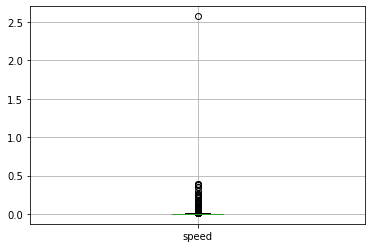

In [17]:
#Visualize speed feature
train.boxplot(column='speed', return_type='axes');

In [18]:
#Remove speed outliers
train = train[(train.speed < 0.5)]

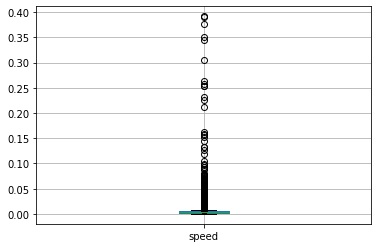

In [19]:
#Visualize speed feature
train.boxplot(column='speed', return_type='axes');

### 시간: 픽업시간 (시간 -> 요일(평일/주말(공휴일)))

In [ ]:
InteractiveShell.ast_node_interactivity = "none"

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(20, 10))

# 날짜별 분포
ymd = train.pickup_datetime.dt.strftime('%Y-%m-%d').value_counts().sort_index()
ax[0].set_title('date hist')
ax[0].set_xlabel('date')
ax[0].set_ylabel('count')
ax[0].plot(ymd)

# 평일/주말 분포 # (0:월, 1:화, 2:수, 3:목, 4:금, 5:토, 6:일)
wk = train.pickup_datetime.dt.weekday.value_counts().sort_index()
ax[1].set_title('weekday hist')
ax[1].set_xlabel('weekday')
ax[1].set_ylabel('count')
ax[1].plot(wk)


# 시간별 분포 
hr = train.pickup_datetime.dt.strftime('%H').value_counts().sort_index()
ax[2].set_title('hour hist')
ax[2].set_xlabel('hour')
ax[2].set_ylabel('count')
ax[2].plot(hr)

plt.show()

In [ ]:
InteractiveShell.ast_node_interactivity = "all"

#### 1) date hist: 특정 날에 건수가 없는 날이 있음 제외 고려, 년/월/일/시 쪼개서 넣을것인가? 저 특이한 날은 제외하는게 학습에 도움이 되는가? 상관이 없는가? count 가 적으므로 dist 도 적어질테니까 없애는게 나을거 같은데... 
#### 2) weekday hist(0:월, 1:화, 2:수, 3:목, 4:금, 5:토, 6:일): 요일별 편차가 존재함
#### 3) hour hist: 새벽시간 건수가 적음 -> 시간별로 묶는 변수를 추가할까? 

In [ ]:
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(20, 10))

# 시간별 탑승 건수
datetimeCnt = train.pickup_datetime.dt.strftime('%Y-%m-%d %H').value_counts().sort_index()

ax.set_title('datetime - count')
ax.set_xlabel('datetime')
ax.set_ylabel('count')
ax.plot(datetimeCnt)

plt.show()

In [ ]:
# 거리 분포
train.dist.plot()

In [ ]:
train['dist'].groupby(train.pickup_datetime.dt.strftime('%Y-%m-%d')).sum()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(20, 10))

# 날자별 탑승 거리 
dateDist = train['dist'].groupby(train.pickup_datetime.dt.strftime('%Y-%m-%d')).sum()

ax.set_title('date - dist')
ax.set_xlabel('date')
ax.set_ylabel('dist')
ax.plot(dateDist)

plt.show()

In [ ]:
dateDist[dateDist == dateDist.min()]

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(20, 10))

# 날자별 탑승 거리 
dateDist_drop = train_drop['dist'].groupby(train_drop.pickup_datetime.dt.strftime('%Y-%m-%d')).sum()

ax.set_title('date - dist')
ax.set_xlabel('date')
ax.set_ylabel('dist')
ax.plot(dateDist_drop)

plt.show()

In [ ]:
dateDist_drop[dateDist_drop == dateDist_drop.min()]

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(20, 10))

# 날자별 탑승 거리 
dateDist_drop = train_drop['dist'].groupby(train_drop.pickup_datetime.dt.strftime('%Y-%m-%d')).sum()

ax.set_title('date - dist')
ax.set_xlabel('date')
ax.set_ylabel('dist')
ax.plot(dateDist_drop)

plt.show()

## 클러스터링
### 지역 클러스터: 경도/위도
-> 거리 
### 시간 클러스터: 픽업시간 시간 
-> 요일(평일/주말(공휴일)))

=> 클러스터링 결과로?
1) 클러스터로 묶어서 레코드를 추가할 수도 있고
2) 클러스터끼리 학습할 수도 있을것 같고

In [ ]:
# Feature Extraction
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))

In [ ]:
kmeans = MiniBatchKMeans(n_clusters=3, init='k-means++').fit(coords)

In [ ]:
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

In [ ]:
pca = PCA().fit(coords)
train['pickup_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 0]
train['pickup_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 1]
train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
test['pickup_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 1]
test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

In [ ]:
InteractiveShell.ast_node_interactivity = "all"

In [26]:
# 년도는 동일, 월, 일, 시간, 요일 추출 
train['pickup_mm'] = train.pickup_datetime.dt.strftime('%m').astype('int')
train['pickup_dd'] = train.pickup_datetime.dt.strftime('%d').astype('int')
#train['pickup_date'] = train.pickup_datetime.dt.strftime('%m%d')
train['pickup_day'] = train['pickup_datetime'].dt.day
train['pickup_hour'] = train['pickup_datetime'].dt.hour
train['minute_oftheday'] = train['pickup_hour'] * 60 + train.pickup_datetime.dt.minute
train['pickup_weekday'] = train.pickup_datetime.dt.weekday
train['pickup_week'] = train.pickup_datetime.dt.week#dayofweek

test['pickup_mm'] = test.pickup_datetime.dt.strftime('%m').astype('int')
test['pickup_dd'] = test.pickup_datetime.dt.strftime('%d').astype('int')
#test['pickup_date'] = test.pickup_datetime.dt.strftime('%m%d')
test['pickup_day'] = test['pickup_datetime'].dt.day
test['pickup_hour'] = test['pickup_datetime'].dt.hour
test['minute_oftheday'] = test['pickup_hour'] * 60 + test.pickup_datetime.dt.minute
test['pickup_weekday'] = test.pickup_datetime.dt.weekday
test['pickup_week'] = train.pickup_datetime.dt.week#dayofweek

## 인코딩

In [ ]:
train.columns

In [6]:
train = pd.get_dummies(train, columns=['vendor_id'], prefix='vendor_id')
test = pd.get_dummies(test, columns=['vendor_id'], prefix='vendor_id')

In [7]:
train = pd.get_dummies(train, columns=['store_and_fwd_flag'], prefix='store_and_fwd_flag')
test = pd.get_dummies(test, columns=['store_and_fwd_flag'], prefix='store_and_fwd_flag')

## corr

In [ ]:
columns = [
           #'vendor_id'
           'vendor_id_1','vendor_id_2',
    
           'passenger_count'
    
           #, 'pickup_datetime'
           #,'pickup_date'
    
           ,'pickup_mm'
           ,'pickup_day','pickup_hour','pickup_weekday'
           ,'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'
           ,'dist'
           ,'store_and_fwd_flag'
           #,'store_and_fwd_flag_N','store_and_fwd_flag_Y'
            ,'trip_duration'
          ]
train_corr = train[columns]
train_corr.head()

In [ ]:
plt.figure(figsize=(14, 12))
sns.heatmap(train_corr.corr(), linewidths=0.1, vmax=1.0,
           square=True, cmap=plt.cm.RdBu, linecolor='white', annot=True, fmt='.3f', annot_kws={"size": 16})

In [ ]:
#Correlations between variables
fig, ax = plt.subplots(figsize=(14,5))  
sns.heatmap(data=train.corr(), annot=True, cmap = plt.cm.RdYlBu_r, linewidths=.1, ax=ax).set_title('Correlations between variables');

# 3. 모델학습

In [20]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb

In [ ]:
train.columns

In [ ]:
test.columns

In [29]:
#train.columns

columns = [
           'passenger_count'       
           ,'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'
           ,'store_and_fwd_flag_N','store_and_fwd_flag_Y'       
           ,'vendor_id_1','vendor_id_2'
    
           ,'pickup_mm'#,'pickup_dd'
           ,'pickup_week','pickup_weekday','pickup_hour','minute_oftheday'
           #,'pickup_minute'
           #, 'pickup_datetime'
           #,'pickup_date'
    
           
           #,'pickup_day'
           
           #,'pickup_week'
           
           #,'pickup_weekday_0','pickup_weekday_1','pickup_weekday_2'
           #,'pickup_weekday_3','pickup_weekday_4','pickup_weekday_5','pickup_weekday_6'
           
    
           #,'dist'
           
           #,'store_and_fwd_flag'
           #,'store_and_fwd_flag_0','store_and_fwd_flag_1'
           
    
           #,'pickup_cluster', 'dropoff_cluster'
    
          #, 'pickup_pca0', 'pickup_pca1','dropoff_pca0', 'dropoff_pca1'
    
          #,'total_distance'
           #, 'total_travel_time'#, 'number_of_steps'
    
           , 'distance'
           , 'direction'
          ]
X_train = train[columns]
#y_train = train['trip_duration']
y_train = np.log1p(train['trip_duration'])

X_test = test[columns]

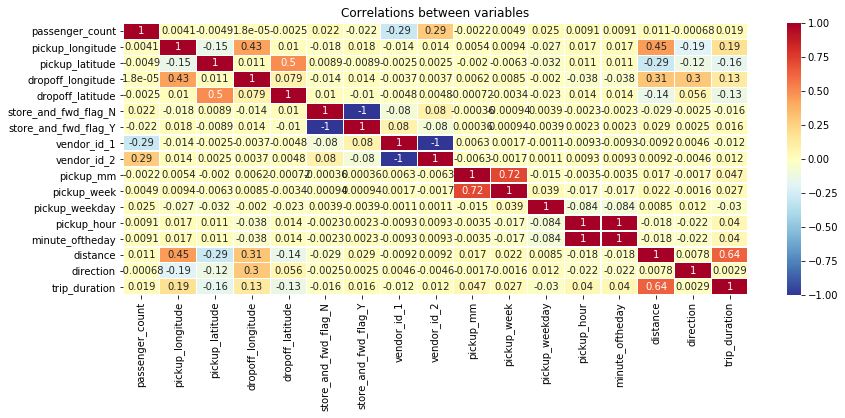

In [30]:
#Correlations between variables
corr_df = pd.concat([X_train, y_train], axis=1)
fig, ax = plt.subplots(figsize=(14,5))  
sns.heatmap(data=corr_df.corr(), annot=True, cmap = plt.cm.RdYlBu_r, linewidths=.1, ax=ax).set_title('Correlations between variables');

In [ ]:
X_train.head()
X_train.info()  # 1458637 

In [ ]:
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import KFold

In [ ]:
n_iter = 0
cv_score = []
xgb_reg = XGBRegressor()

kfold = KFold(n_splits=5)
for train_index, test_index in kfold.split(X_train):
    _X_train, _X_test = X_train.iloc[train_index], X_train.iloc[test_index]
    _y_train, _y_test = y_train.iloc[train_index], y_train.iloc[test_index]
    
    xgb_reg.fit(_X_train, _y_train)
    pred = xgb_reg.predict(_X_test)
    n_iter += 1
    
    cv_score.append(mean_squared_log_error(_y_test, pred))
    
print(np.mean(cv_score))

In [ ]:
from sklearn.model_selection import cross_val_score, cross_validate

In [ ]:
xgb_reg = XGBRegressor()
scores = cross_val_score(xgb_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=3)

rmse_score = np.sqrt(-scores) 
print('mean', np.mean(rmse_score))

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
model = RandomForestRegressor()

grid_parameters = {'max_depth':[18,21]
                  #,'subsample': [0.6, 0.8, 1.0]
                  }

grid_model = GridSearchCV(model, param_grid=grid_parameters, cv=3, refit=True)
grid_model.fit(X_train, y_train)

In [ ]:
score_df = pd.DataFrame(grid_model.cv_results_)
score_df[score_df['rank_test_score'] == 1]

In [ ]:
y_pred_xgb = grid_model.predict(X_test)
#sample_submission['trip_duration'] = y_pred_xgb
sample_submission['trip_duration'] = np.expm1(y_pred_xgb)
sample_submission.to_csv('./output/20200825-3.csv', index=False)

In [31]:
lgb_params = {
    #'metric' : 'rmse',
    'learning_rate': 0.1,
    'max_depth': 25,
    'num_leaves': 1000, 
    'objective': 'regression',
    'feature_fraction': 0.9,
    'bagging_fraction': 0.5,
    'max_bin': 1000 }

In [32]:
%%time
#Training on all labeled data using the best parameters
lgb_df = lgb.Dataset(X_train, y_train)
lgb_model = lgb.train(lgb_params, lgb_df, num_boost_round=1500)

Wall time: 5min 6s


In [33]:
# RandomForestRegressor
y_pred_rf = lgb_model.predict(X_test)
#sample_submission['trip_duration'] = y_pred_rf
sample_submission['trip_duration'] = np.expm1(y_pred_rf)
sample_submission.to_csv('./output/20200827-7.csv', index=False)

In [ ]:
rf_reg = RandomForestRegressor(n_jobs=-1)
rf_reg.fit(X_train, y_train)

In [ ]:
xgb_reg = XGBRegressor()
xgb_reg.fit(X_train, y_train)

In [ ]:
lgb_reg = LGBMRegressor()
lgb_reg.fit(X_train, y_train)

oneHot-store_and_fwd_flag-LinearRegression
oneHot-store_and_fwd_flag-RandomForestRegressor
oneHot-store_and_fwd_flag-XGBRegressor
oneHot-store_and_fwd_flag-LGBMRegressor

In [ ]:
# RandomForestRegressor
y_pred_rf = rf_reg.predict(X_test)
#sample_submission['trip_duration'] = y_pred_rf
sample_submission['trip_duration'] = np.expm1(y_pred_rf)
sample_submission.to_csv('./output/20200827-3.csv', index=False)

In [ ]:
# XGBRegressor
y_pred_xgb = xgb_reg.predict(X_test)
#sample_submission['trip_duration'] = y_pred_xgb
sample_submission['trip_duration'] = np.expm1(y_pred_xgb)
sample_submission.to_csv('./output/20200825-1.csv', index=False)

In [ ]:
# LGBMRegressor
y_pred_lgb = lgb_reg.predict(X_test)
#sample_submission['trip_duration'] = y_pred_lgb
sample_submission['trip_duration'] = np.expm1(y_pred_lgb)
sample_submission.to_csv('./output/20200824-6.csv', index=False)

dayofweek - RandomForestRegressor

dayofweek - XGBRegressor
dayofweek - LGBMRegressor

In [ ]:
model = rf_reg 

frt_importances = pd.Series(model.feature_importances_, index=X_test.columns)

ftr_top = frt_importances.sort_values(ascending=False)[:10]

sns.barplot(x=ftr_top, y=ftr_top.index)

In [ ]:
model = xgb_reg 

frt_importances = pd.Series(model.feature_importances_, index=X_test.columns)

ftr_top = frt_importances.sort_values(ascending=False)[:10]

sns.barplot(x=ftr_top, y=ftr_top.index)

In [ ]:
model = lgb_reg 

frt_importances = pd.Series(model.feature_importances_, index=X_test.columns)

ftr_top = frt_importances.sort_values(ascending=False)[:10]

sns.barplot(x=ftr_top, y=ftr_top.index)

In [35]:
import gc
gc.collect()

20